# Plot SSH variance from ORCA12 (estimate of EKE...)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
from dask.distributed import Client, LocalCluster, wait
from matplotlib.animation import FuncAnimation

In [2]:
plt.style.use('dark_background')

In [3]:
cluster = LocalCluster(n_workers=8, threads_per_worker=2, memory_limit=32e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39111 instead
  expected, actual


In [4]:
client

Client Scheduler: tcp://127.0.0.1:36669 Dashboard: http://127.0.0.1:39111/status,Cluster Workers: 8 Cores: 16 Memory: 238.42 GiB


## Read mesh

In [5]:
ds_m = xr.open_dataset('/gxfs_work1/geomar/smomw352/mask_orca12.nc')
tmask = ds_m['tmask'][0,:,:,:]
ds_h = xr.open_dataset('/gxfs_work1/geomar/smomw352/mesh_hgr_orca12.nc')
e1t = ds_h['e1t'][0,:,:]
e2t = ds_h['e2t'][0,:,:]
areacello = e1t * e2t

In [6]:
areacello

<xarray.DataArray (y: 3059, x: 4322)>
array([[4.33837030e+06, 4.33837030e+06, 4.33837030e+06, ...,
        4.33837030e+06,            nan,            nan],
       [4.35068383e+06, 4.35068383e+06, 4.35068383e+06, ...,
        4.35068383e+06,            nan,            nan],
       [4.36303200e+06, 4.36303200e+06, 4.36303200e+06, ...,
        4.36303200e+06,            nan,            nan],
       ...,
       [2.60772135e+03, 3.96432120e+01, 3.11167740e+03, ...,
        3.12633844e+03,            nan,            nan],
       [2.18179728e+03, 4.95174837e+01, 3.81565733e+03, ...,
        3.81505769e+03,            nan,            nan],
       [2.74519404e+03, 3.32983937e+01, 2.24098055e+03, ...,
        2.76110678e+03,            nan,            nan]])
Dimensions without coordinates: y, x

In [7]:
def global_sfcmean(data, xlim=[-1,-1], ylim=[-1,-1]):
    
    if xlim[0] == -1 or ylim[0] == -1:
        weights = (areacello * tmask[0,:,:]).fillna(0)
        weights.name = "weights"
        data_weighted = data.weighted(weights)
    else:
        weights = (areacello[ylim[0]:ylim[1],xlim[0]:xlim[1]] * tmask[0,ylim[0]:ylim[1],xlim[0]:xlim[1]]).fillna(0)
        weights.name = "weights"
        data_weighted = data[:,ylim[0]:ylim[1],xlim[0]:xlim[1]].weighted(weights)
    
    print(data_weighted)
    weighted_mean = data_weighted.mean(("x", "y"))
        
    return weighted_mean

## Read data

In [8]:
# BJK016 - spinup of Jan 1950
# BJK017 - Feb 1950 - Dec 1952 (until crash)
# BJK019 - cont of BJK019 with changed land mask

expnames = ['FOCI_BJK017','FOCI_BJK019']
times = [slice('1950-02-01','1952-12-31'),slice('1953-01-01','1959-12-31')]

In [10]:
# Put each experiment in a list 
t_5d_all = []

for i, (exp,time) in enumerate( zip(expnames, times) ):
    
    time_str = '*'
    chunks = {'x':200, 'y':200}
    
    ddir = '/gxfs_work1/geomar/smomw352/esm-experiments/%s/outdata/nemo/' % (exp,)
    tfiles = '%s/%s_5d_%s_grid_T.nc' % (ddir,exp,time_str)
    print(tfiles)
    t_5d = xr.open_mfdataset(tfiles,combine='by_coords', chunks=chunks).rename({'time_counter':'time'}).sel(time=time)
    
    t_5d_all.append(t_5d)

/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK017/outdata/nemo//FOCI_BJK017_5d_*_grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK019/outdata/nemo//FOCI_BJK019_5d_*_grid_T.nc


In [ ]:
t_5d.chunk({'time':-1})

## SSH variance

In [20]:
chunks = {'x':200, 'y':200, 'time':-1}

ssh_all = []

for ds_t in t_5d_all:
    _ssh = ds_t['ssh'].chunk(chunks)
    #_ssh_mean = global_sfcmean(_ssh)
    #print('compute ssha')
    #_ssha = _ssh - _ssh_mean
    #_ssh_y = _ssh.groupby('time.year').mean('time')
    #_ssha = _ssh.groupby('time.year') - _ssh_y 
    
    _ssh_roll = _ssh.rolling(time=90, center=True).mean().chunk(dict(time=-1))
    _ssh_mean = _ssh_roll.interpolate_na(dim='time',
                                         method='linear',
                                         fill_value='extrapolate')
    _ssha = _ssh - _ssh_mean
    print('compute ssha**2')
    _ssh2 = _ssha**2
    ssh_all.append(_ssh2)

compute ssha**2
compute ssha**2


In [23]:
_ssh_mean.isel(x=3000,y=2000)

<xarray.DataArray 'ssh' (time: 437)>
dask.array<getitem, shape=(437,), dtype=float64, chunksize=(437,), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (time) float32 dask.array<chunksize=(437,), meta=np.ndarray>
    nav_lon        (time) float32 dask.array<chunksize=(437,), meta=np.ndarray>
    time_centered  (time) datetime64[ns] dask.array<chunksize=(437,), meta=np.ndarray>
  * time           (time) datetime64[ns] 1953-01-03T12:00:00 ... 1959-02-23T1...
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    average
    interval_operation:  300 s
    interval_write:      5 d
    cell_methods:        time: mean (interval: 300 s)

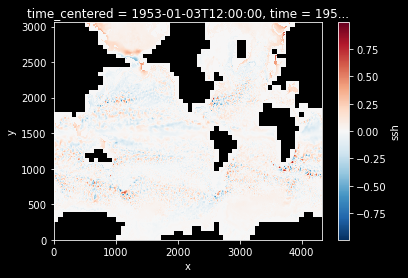

In [39]:
_ssha.isel(time=0).plot()

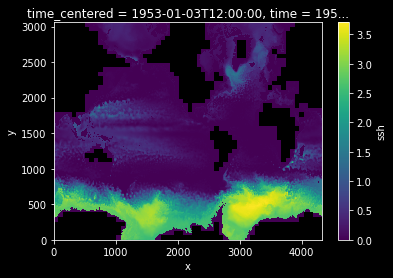

In [36]:
_ssh2.isel(time=0).plot()

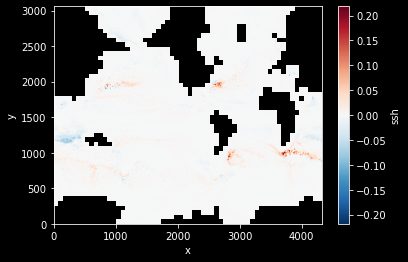

In [42]:
(ssh_all[1].mean('time') - ssh_all[0].mean('time')).plot()

## Observations

## Global mean SSH2

In [24]:
ssh_mean_all = []
for _ssh2 in ssh_all:
    ssh_mean = global_sfcmean(_ssh2).compute()
    ssh_mean_all.append(ssh_mean)

DataArrayWeighted with weights along dimensions: y, x
DataArrayWeighted with weights along dimensions: y, x


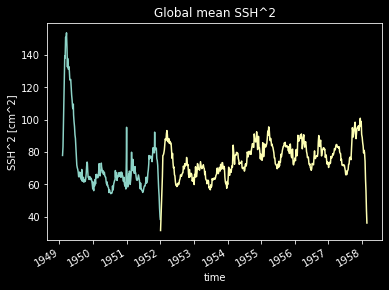

In [26]:
fig1, ax1 = plt.subplots(1,1)

for _ssh in ssh_mean_all:
    (_ssh*1e4).plot(ax=ax1)
    
ax1.set_ylabel('SSH^2 [cm^2]')
ax1.set_title('Global mean SSH^2')
fig1.savefig('figures/global_mean_ssh2.pdf',format='pdf')

In [14]:

ssh_mean_all = []

xlim = [2517, 3897]
ylim = [61,   1111]

for _ssh2 in ssh_all:
    ssh_mean = global_sfcmean(_ssh2, xlim=xlim, ylim=ylim).compute()
    ssh_mean_all.append(ssh_mean)
    


DataArrayWeighted with weights along dimensions: y, x
DataArrayWeighted with weights along dimensions: y, x


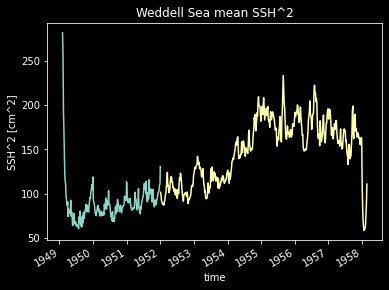

In [15]:
fig1, ax1 = plt.subplots(1,1)

for _ssh in ssh_mean_all:
    (_ssh*1e4).plot(ax=ax1)
    
ax1.set_ylabel('SSH^2 [cm^2]')
ax1.set_title('Weddell Sea mean SSH^2')
fig1.savefig('figures/weddell_sea_ssh2.pdf',format='pdf')

In [16]:
ssh_mean_all = []

xlim = [2450, 2900]
ylim = [1850, 2200]

for _ssh2 in ssh_all:
    ssh_mean = global_sfcmean(_ssh2, xlim=xlim, ylim=ylim).compute()
    ssh_mean_all.append(ssh_mean)

DataArrayWeighted with weights along dimensions: y, x
DataArrayWeighted with weights along dimensions: y, x


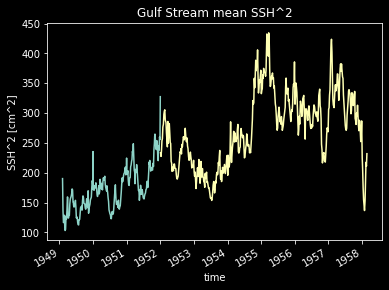

In [17]:
fig1, ax1 = plt.subplots(1,1)

for _ssh in ssh_mean_all:
    (_ssh*1e4).plot(ax=ax1)
    
ax1.set_ylabel('SSH^2 [cm^2]')
ax1.set_title('Gulf Stream mean SSH^2')
fig1.savefig('figures/gulf_stream_ssh2.pdf',format='pdf')